# Bayesian example with continuous distributions
### by Elizabeth Barnes

You are interested in measuring the sea-surface temperature (SST) off of the Washington coast to within 0.1 units. You know from previous years that the distribution of anomalous sea-surface temperature (denoted as random variable $X$) follows a uniform distribution with bounds $(-2,2)$. The problem is that the instrument you use to measure the temperature is known to introduce an additive error. While the exact error during each measurement is unknown, you know from calibration that the error follows a normal distribution with $\mu = 0$ and $\sigma = 0.75$, denoted at $W$. That is, you measure a random variable $Y$ that is the sum of the two random variables $X$ and $W$: $Y = X + W$.

You go out and take a measurement and the instrument says that the anomalous sea-surface temperature is $y = 2.2$. (a) What is the probability that $X = x \pm \epsilon$ given that you measured $y$, or in math, $\textbf{Pr}({X = x \pm \epsilon | Y = 2.2 \pm \epsilon)}$ for some range determined by $\epsilon$? (b) For each possible value of $y$, what is your best estimate of $x$? 

### Part (a): What is the probability that $X = x \pm \epsilon$ given that you measured $y$, or in math, $\textbf{Pr}({X = x \pm \epsilon | Y = 2.2 \pm \epsilon)}$ for some range determined by $\epsilon$?

In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-

#.............................................
# IMPORT STATEMENTS
#.............................................
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats

#conda install -c conda-forge pymc3
import pymc3 as pm

#.............................................
# PLOTTING COMMANDS
#.............................................
import matplotlib as mpl
import seaborn as sns

# set figure defaults
linewidth_default = 2.0
fig_text_default = 18.
fig_title_default = fig_text_default*1.5

plt.rc('lines', linewidth=linewidth_default)    
plt.rc('text', usetex=False)
plt.rc('font', size=fig_text_default, weight='normal',family='sans-serif')
plt.rc('axes',titlesize=fig_title_default,titleweight='bold')
mpl.rcParams['figure.dpi'] = 100
#mpl.rcParams['xtick.labelsize'] = fig_text_default

In [2]:
def computeCDF(x,val):
    p = len(x[x<=val])/len(x)
    return p

Before we get too far into anything, let's start by plotting the distributions that we know. Namely, we know that SSTs, $X$, follows a uniform distribution, and that the error follows a non-standard normal distribution. Let's plot these and take a look at them.

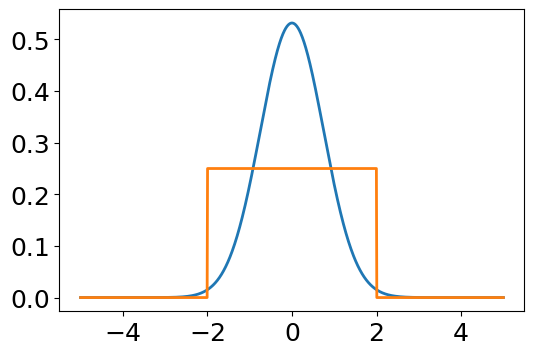

In [3]:
mu_w = 0.
var_w = 0.75

with pm.Model() as model:
    W = pm.Normal('W', mu=mu_w, sigma=var_w)
    X = pm.Uniform('X', lower=-2, upper=2)
    Y = pm.Deterministic('Y', W+X)

x = np.linspace(-5., 5, 1000)
plt.plot(x,np.exp(W.distribution.logp(x).eval()))
plt.plot(x,np.exp(X.distribution.logp(x).eval()))
plt.show()    

In [4]:
with model:
    trace = pm.sample(1000000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [X, W]
Sampling chain 0, 0 divergences: 100%|██████████| 1000500/1000500 [27:13<00:00, 612.50it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


These look like we expect. The question is, what is the distribution of $Y = X + W$? This is actually not so obvious. One way we could figure this out is by actually creating two random variables $X$ and $W$ and adding individual samples together for millions and millions of pairs and then plotting *that* distribution. We could do this, or we could use the nifty pacal package - which is a single line.

Now, let's plot the distribution of $X, W$ and their sum $Y$.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5c8560be0>,
      dtype=object)

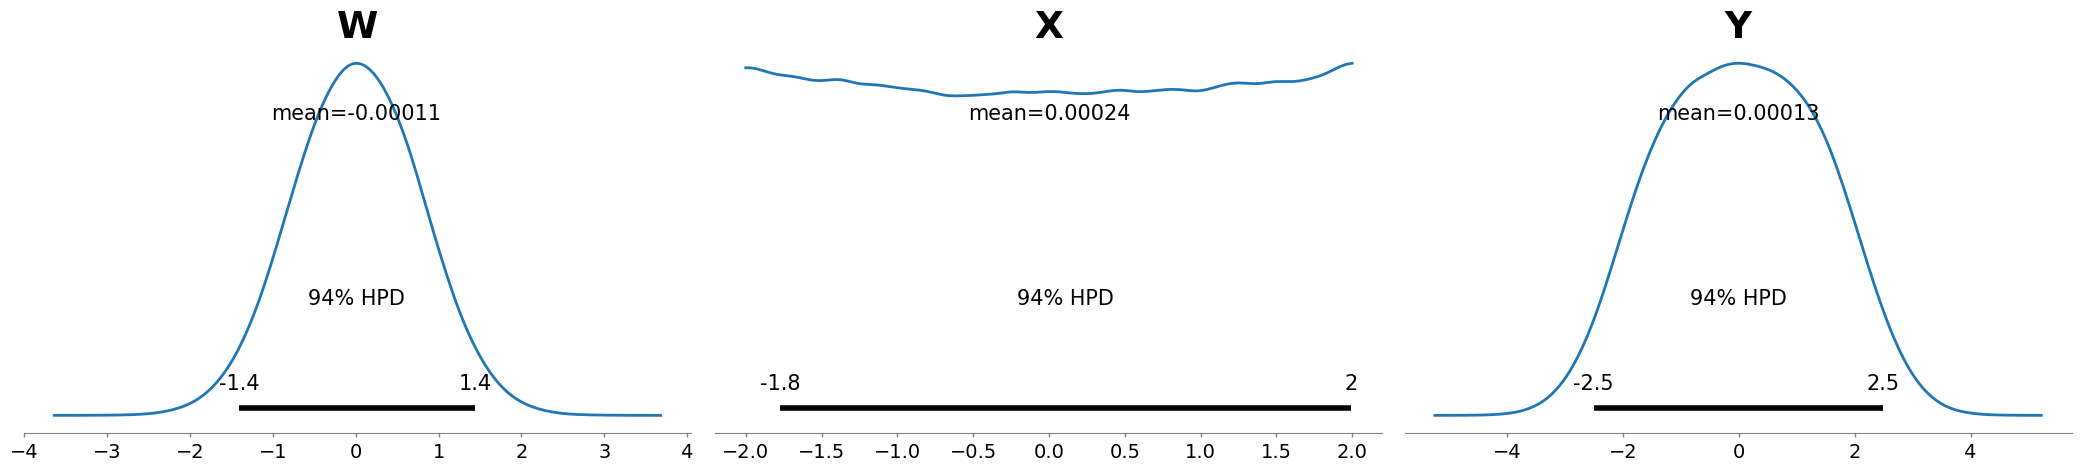

In [5]:
pm.plot_posterior(trace)

/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5bfc61240>,
      dtype=object)

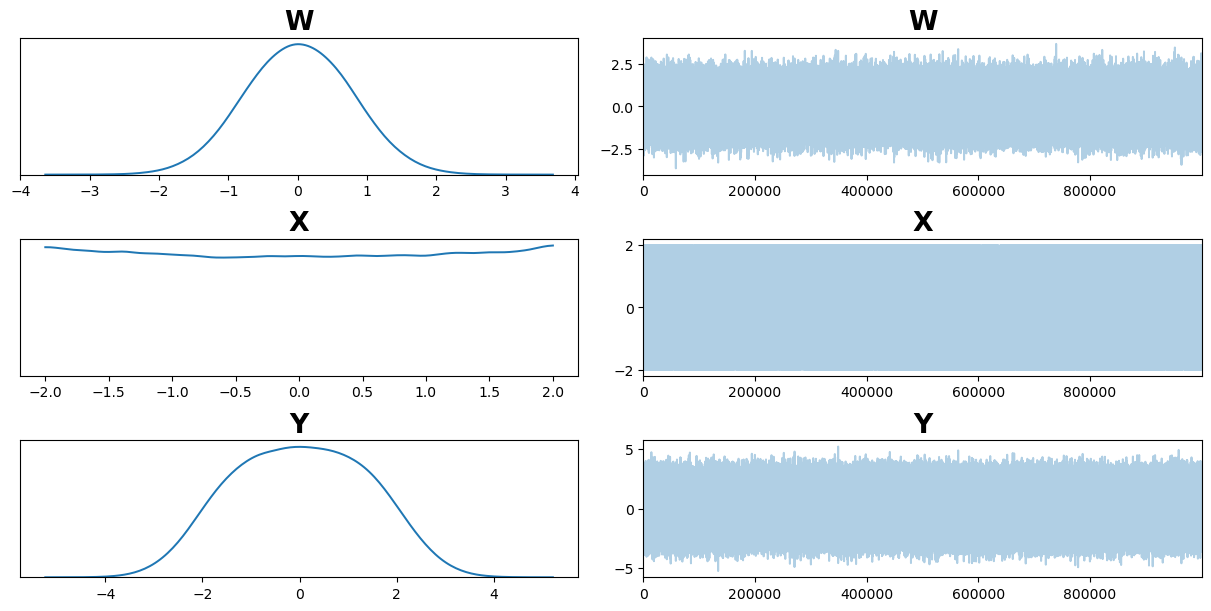

In [6]:
pm.traceplot(trace)

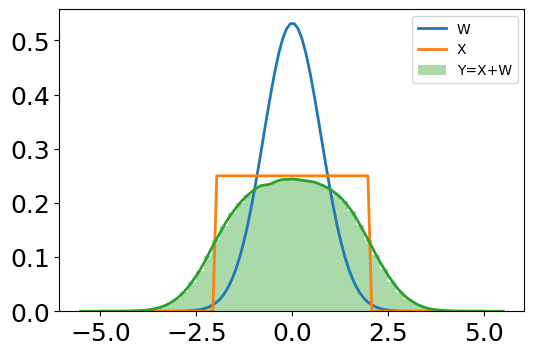

In [7]:
plt.figure()
x = np.linspace(-5., 5, 100)
plt.plot(x,np.exp(W.distribution.logp(x).eval()),label='W')
plt.plot(x,np.exp(X.distribution.logp(x).eval()), label='X')
sns.distplot(trace['Y'], label='Y=X+W')
plt.legend(fontsize=10)
plt.show()

In [8]:
yvals = trace['Y']
xvals = trace['X']
wvals = trace['W']
print(np.shape(yvals))
print(np.shape(xvals))
print(np.shape(wvals))

(1000000,)
(1000000,)
(1000000,)


Looking at the green curve $Y$, perhaps you are not surprised that it lies somewhere "in the middle" of the two other distributions. Either way - there it is! Now we can move forward with the problem at hand, now knowing the distrubtion of the sum of the SST measurements ($X$) with the random measurement error ($W$).

We can now use Bayes' Theorem to compute what we want to know, namely
\begin{equation}
\textbf{Pr}(X = x \pm \epsilon |Y = y = 2.2 \pm \epsilon) = \frac{\textbf{Pr}(Y = y \pm \epsilon | X = x \pm \epsilon) \textbf{Pr}(X = x \pm \epsilon)} {\textbf{Pr}(Y = y \pm \epsilon)}
\end{equation}
where $\epsilon$ is determined by you. Here, we will let $\epsilon = 0.05$.

You know that $X$ follows a uniform distribution, and the distribution of $Y$ given $X = x$ follows the normal distribution of $W$ but centered on $\mu = x$ instead of zero. Determining the distribution of $Y$ is a bit trickier, but we used the pacal module to figure it out. 

Plugging these distributions into Bayes' Theorem leads to...


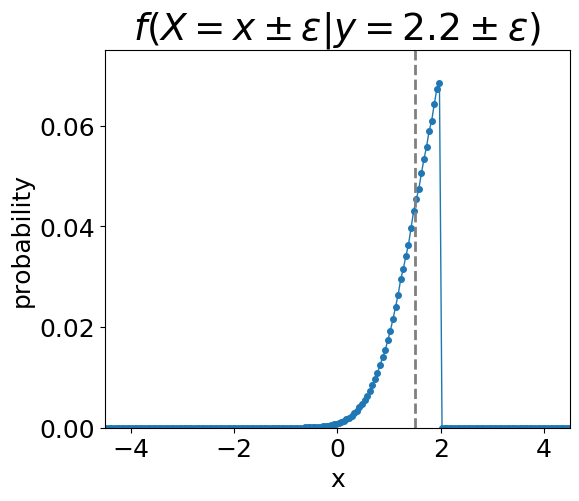

In [9]:
inc = .05
yout = 2.2

xvec = np.arange(-6.+inc/2.,6.+inc/2.,inc)

fx_y_expectation = []
fx_y = []       

# probability of Y = yout
fy = computeCDF(yvals,yout+inc/2.) - computeCDF(yvals,yout-inc/2.)

for xout in xvec:

    # probability of Y=2.2 given X=x is just the error distribution about x
    fy_x = stats.norm.cdf(yout+inc/2.,loc = xout,scale = var_w) - stats.norm.cdf(yout-inc/2.,loc = xout,scale = var_w)

    # probability that x = xout
    fx = computeCDF(xvals,xout+inc/2.) - computeCDF(xvals,xout-inc/2.)

    a = (fy_x * fx/fy)

    fx_y.append(a)

fx_y = np.array(fx_y)
fx_y_expectation = np.sum(xvec * fx_y)

plt.figure(figsize=(6,5))
plt.plot(xvec,fx_y, 'o-', markersize = 4, linewidth = 1)

#print np.sum(fx_y)
#print np.trapz(fx_y/inc, dx=inc)
plt.plot([fx_y_expectation,fx_y_expectation],[0,.14],'--',color = 'gray')

plt.xlim(-4.5,4.5)
plt.ylim(0,0.075)
plt.xlabel('x')
plt.title('$\mathit{f}(X = x \pm \epsilon | y = ' + str(yout) + ' \pm \epsilon)$')
plt.ylabel('probability')

plt.show()

We see that the probability that $x$ falls within a given interval increases for larger $x$, since we know that $y$ itself is 2.2, and so, to have, say, a negative $x$, we would need to have had a very large error when measuring that sample. The probability goes to zero above 2.0 because we know a priori that $x$ cannot be larger than this. 

The dashed gray line denotes the conditional expectation of $X$ based on $Y$, that is - the expectation of $X$ given that $y = 2.2 \pm \epsilon$. 

### Part (b): For each possible value of $y$, what is your best estimate of $x$? 

To answer this, you must decide what you mean by "best estimate". Here, we will define the best estimate based on the posteriori mean. That is, the best estimate of $X$ given $Y = y$ is defined by the *minimum mean squared error estimate*, which is just the expected value of $X$ given $Y = y$. In the case of $Y = y = 2.2$, the best estimate is $x = 1.46$ as shown by the gray dashed line above.

For other y-values, we need to iterate through them, perform the same calculation as above, and plot the result as a function of $y_{out}$, as shown below.

In [10]:
inc = .05

xvec = np.arange(-6.+inc/2.,6.+inc/2.,inc)
yout_vec = xvec
yout = []

fx_y_expectation = []

for yout in yout_vec: #loop through many possibilites of y, not just y = 2.2

    fx_y = []       
    
    # probability of Y = yout
    fy = computeCDF(yvals,yout+inc/2.) - computeCDF(yvals,yout-inc/2.)
    
    for xout in xvec:

        # probability of Y=2.2 given X=x is just the error distribution about x
        fy_x = stats.norm.cdf(yout+inc/2.,loc = xout,scale = var_w) - stats.norm.cdf(yout-inc/2.,loc = xout,scale = var_w)

        # probability that x = xout
        fx = computeCDF(xvals,xout+inc/2.) - computeCDF(xvals,xout-inc/2.)
        a = (fy_x * fx/fy)

        fx_y.append(a)

    fx_y = np.array(fx_y)
    fx_y_expectation.append(np.sum(xvec.astype(float) * fx_y))

Now we plot the results.

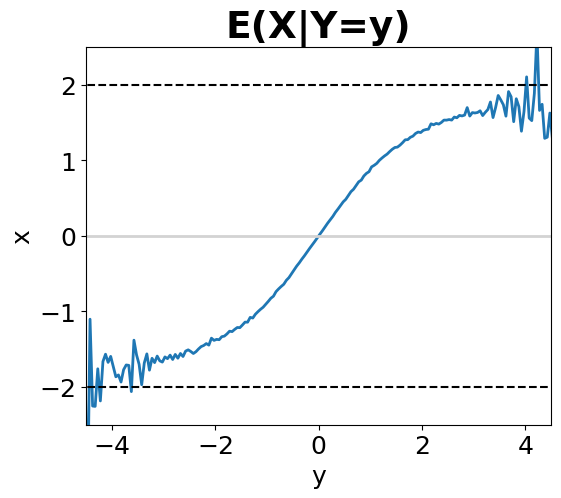

In [11]:
plt.figure(figsize=(6,5))
plt.plot(yout_vec,fx_y_expectation)    
plt.xlabel('y')
plt.title('E(X|Y=y)')
plt.ylabel('x')

plt.xlim(-4.5,4.5)
plt.ylim(-2.5,2.5)
plt.axhline(color='lightgray')

plt.plot([-60,60],[-2,-2],'--',linewidth = 1.5, color = 'black')
plt.plot([-60,60],[2,2],'--',linewidth = 1.5, color = 'black')

plt.show()

Performing these calculations for all possible values of $y$ leads to the figure above, which shows the most likely sea-surface temperature given that you measure a particular value of $y$. Note how the curve slowly approaches -2 and 2 since $X$ is bounded by these two values.

*To see any updated versions of this notebook, visit https://github.com/eabarnes1010/ats655-coursematerial/blob/master/jupyter_notebooks/bayesian_sst_example.ipynb*